In [9]:
import sys  
sys.path.insert(0, '../')
from torchvision import transforms
import torch
import torch.nn as nn
import numpy as np
import json
import os
import time
from argparse import ArgumentParser
from tools.datasets import ImageNet, ImageNet9
from tools.model_utils import make_and_restore_model, eval_model
from tools.folder import pil_loader
from PIL import Image
import tqdm
from matplotlib import pyplot as plt

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
batch_size = 16
workers = 0
variation = "mixed_rand"
dataset = ImageNet9("../data/"+variation)
checkpoint = "../models\in9l_resnet50.pt"
val_loader = ImageNet9("..\data\original").make_loaders(batch_size=batch_size, workers=workers)
train_loader = ImageNet9("..\data\original").make_loaders(batch_size=batch_size, workers=workers, shuffle_val=True, test = False)

==> Preparing dataset ImageNet9..
==> Preparing dataset ImageNet9..


In [12]:
n_classes = 9
def l_2_onehot(labels,nb_digits=n_classes):
    # take labels (from the dataloader) and return labels onehot-encoded
    #
    # your code here
    #
    label_onehot = torch.FloatTensor(labels.shape[0], nb_digits)
    label_onehot.zero_()
    label_onehot = label_onehot.scatter_(1,labels.unsqueeze(1),1).cpu()

    return label_onehot

In [13]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(nn.Conv2d(3,64,11,4,2),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(3,2,0),
                                      nn.Conv2d(64,192,5,1,2),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(3,2,0),
                                      nn.Conv2d(192,384,3,1,1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(384,256,3,1,1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(256,256,3,1,1),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(3,2,0))
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [14]:
criterion = nn.CrossEntropyLoss()

def accuracy(net, test_loader, cuda=True):
  net.eval()
  correct = 0
  total = 0
  loss = 0
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          if cuda:
            images = images.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          outputs = net(images)
          
          loss += criterion(outputs, labels)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  net.train()

  return 100.0 * correct/ total, loss.item()

In [15]:
def train(net, optimizer, train_loader, test_loader, loss,  n_epoch = 5, test_acc_period = 5, cuda=True):
  loss_train = []
  loss_test = []
  acc_train = []
  acc_test = []
  cur_acc, cur_loss = accuracy(net, train_loader, cuda=cuda)
  print('[%d] train loss: %.3f' %(0, cur_loss))
  print('[%d] train acc: %.3f' %(0, cur_acc))
  cur_acc, cur_loss = accuracy(net, test_loader, cuda=cuda)
  print('[%d] test loss: %.3f' %(0, cur_loss))
  print('[%d] test acc: %.3f' %(0, cur_acc))
  print("####################")
  for epoch in tqdm.tqdm_notebook(range(n_epoch)):  # loop over the dataset multiple times

    for data in train_loader:
      # get the inputs
      inputs, labels = data
      if cuda:
        inputs = inputs.type(torch.cuda.FloatTensor)
        labels = labels.type(torch.cuda.LongTensor)
      # print(inputs.shape)

      # zero the parameter gradients
      optimizer.zero_grad()

      outputs = net(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
        
    if (epoch+1) % test_acc_period == 0:
      cur_acc, cur_loss = accuracy(net, train_loader, cuda=cuda)
      print('[%d] train loss: %.3f' %(epoch + 1, cur_loss))
      print('[%d] train acc: %.3f' %(epoch + 1, cur_acc))
      loss_train.append(cur_loss)
      acc_train.append(cur_acc)
      cur_acc, cur_loss = accuracy(net, test_loader, cuda=cuda)
      print('[%d] test loss: %.3f' %(epoch + 1, cur_loss))
      print('[%d] test acc: %.3f' %(epoch + 1, cur_acc))
      loss_test.append(cur_loss)
      acc_test.append(cur_acc)
      print("####################")
    
  print('Finished Training')
  return loss_train, loss_test, acc_train, acc_test

In [16]:
net = AlexNet(num_classes=9)

# net = AlexNet(10)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print("using cuda")
    net.cuda()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
loss_train, loss_test, acc_train, acc_test = train(net, optimizer, train_loader, val_loader, criterion,  n_epoch = 30, test_acc_period = 5)
accuracy(net, val_loader, cuda=use_cuda)

using cuda
[0] train loss: 558.115
[0] train acc: 11.086
[0] test loss: 558.174
[0] test acc: 11.086
####################


<ipython-input-15-f3b60c03f6f4>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(n_epoch)):  # loop over the dataset multiple times


[5] train loss: 463.354
[5] train acc: 32.963
[5] test loss: 463.888
[5] test acc: 32.963
####################
[10] train loss: 353.228
[10] train acc: 49.654
[10] test loss: 352.367
[10] test acc: 49.654
####################
[15] train loss: 188.598
[15] train acc: 73.827
[15] test loss: 187.843
[15] test acc: 73.827
####################
[20] train loss: 52.344
[20] train acc: 93.605
[20] test loss: 52.341
[20] test acc: 93.605
####################
[25] train loss: 48.740
[25] train acc: 93.605
[25] test loss: 48.354
[25] test acc: 93.605
####################
[30] train loss: 9.672
[30] train acc: 98.914
[30] test loss: 9.674
[30] test acc: 98.914
####################

Finished Training


(98.91358024691358, 9.674269676208496)

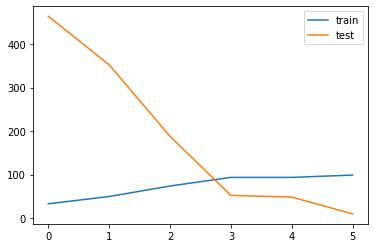

In [17]:
plt.plot(range(len(loss_train)), acc_train, label = "train")
plt.plot(range(len(loss_test)), loss_test, label = "test")
plt.legend()
plt.show()

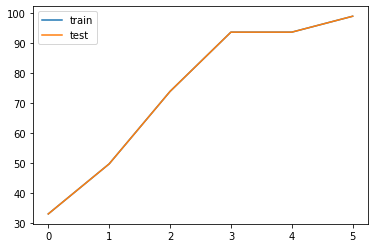

In [18]:
plt.plot(range(len(acc_train)), acc_train, label = "train")
plt.plot(range(len(acc_test)), acc_test, label = "test")
plt.legend()
plt.show()

In [19]:
def accuracy_print(net, test_loader, cuda=True):
  net.eval()
  correct = 0
  total = 0
  loss = 0
  with torch.no_grad():
      for data in test_loader:
          images, labels = data
          if cuda:
            images = images.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
          outputs = net(images)
          
          loss += criterion(outputs, labels)
          _, predicted = torch.max(outputs.data, 1)

          print("###################")
          print(predicted)
          print(labels)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          break

  net.train()
  print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))
  
  return 100.0 * correct/ total, loss.item()

In [20]:
accuracy_print(net, val_loader, cuda=use_cuda)

###################
tensor([0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Accuracy of the network on the test images: 93 %


(93.75, 0.14618191123008728)